# Hyper Tuning a CNN-LSTM Model on Tensorflow Datasets (run on a server)

## Preparation on a server

* create a conda environment with Tensorflow GPU support:
`conda create -n mmproteo tensorflow-gpu python=3.8 jupyter`
    * pay attention that all additional tensorflow packages have (roughly) the same version
* `conda activate mmproteo`
* `pip install -r requirements.txt` (the major `requirements.txt` file from the pride-downloader package, not just the mmproteo one)
* start jupyter server

In [1]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
scheduling priority             (-e) 0
file size               (blocks, -f) unlimited
pending signals                 (-i) 4127177
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 500000
pipe size            (512 bytes, -p) 8
POSIX message queues     (bytes, -q) 819200
real-time priority              (-r) 0
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 4127177
virtual memory          (kbytes, -v) unlimited
file locks                      (-x) unlimited


## Prerequisites

In [2]:
import json
import os
from typing import Callable

import numpy as np
import pandas as pd
import tensorflow as tf
from official.nlp.modeling.layers.position_embedding import RelativePositionEmbedding
import keras_tuner as kt
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [5]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
current_gpu = GPUs[0]
current_gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

## Configuration

In [7]:
%pwd

'/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks'

In [8]:
PROJECT = "PXD010000"

In [9]:
DUMP_PATH = "/scratch/mirko.krause/dumps/" + PROJECT

In [23]:
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

In [11]:
SEQ = 'peptide_sequence'

In [12]:
logger = log.create_logger(
    name='mmproteo_hypertuning_cnn_lstm',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-07-12 19:58:31,963 - mmproteo_hypertuning_cnn_lstm: Logging to file '/scratch/mirko.krause/dumps/PXD010000/mmproteo_hypertuning_cnn_lstm.log' and to stderr


In [13]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'M(Oxidation)',
  '12': 'N',
  '13': 'P',
  '14': 'Q',
  '15': 'R',
  '16': 'S',
  '17': 'T',
  '18': 'V',
  '19': 'W',
  '20': 'Y',
  '21': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f8e5c0cf550>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence']}

In [14]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [15]:
KEEP_CACHE = True

In [16]:
BATCH_SIZE=32

In [17]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [18]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        '*',  # species
        '*'   # istrain
    ),
    path_position = -2,
    splits = {
            TRAINING_TYPE: 0.4,
            TEST_TYPE: 0.5,
            EVAL_TYPE: 0.6
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 89
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_P_polymyxa_TBS_aerobic_1_17July16_Samwise_16-04-10_mzmlid.parquet/Paenibacillus_polymyxa_ATCC842/Train
#Test = 27
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Cj_media_MH_R3_23Feb15_Arwen_14-12-03_mzmlid.parquet/Campylobacter_jejuni/Train
#Eval = 38
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/M_alcali_copp_CH4_B3_T1_11_QE_23Mar18_Oak_18-01-07_mzmlid.parquet/Methylomicrobium_alcaliphilum/Train


2021-07-12 19:58:31,981 - mmproteo_hypertuning_cnn_lstm: found file paths dump '/scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [19]:
element_spec = (
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col], ), dtype=tf.float32, name=col)
     for col in PROCESSING_INFO['training_data_columns']),
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col], ), dtype=tf.int8, name=col)
     for col in PROCESSING_INFO['target_data_columns'])
)
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name=None),
  TensorSpec(shape=(2354,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(50,), dtype=tf.int8, name=None),))

**In the following step, Tensorflow starts allocating a GPU**

In [22]:
# initialize Tensorflow (might take several minutes (~5))
tf.data.Dataset.range(5)

<RangeDataset shapes: (), types: tf.int64>

In [24]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [28]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-07-12 20:13:34,421 - mmproteo_hypertuning_cnn_lstm: DEBUG: preparing dataset 'Train' with 89 paths
2021-07-12 20:13:34,423 - mmproteo_hypertuning_cnn_lstm: DEBUG: applied options to dataset 'Train'
2021-07-12 20:13:34,434 - mmproteo_hypertuning_cnn_lstm: DEBUG: loaded dataset 'Train' interleaved
2021-07-12 20:13:34,434 - mmproteo_hypertuning_cnn_lstm: DEBUG: shuffled dataset 'Train'
2021-07-12 20:13:34,435 - mmproteo_hypertuning_cnn_lstm: DEBUG: batched dataset 'Train'
2021-07-12 20:13:34,435 - mmproteo_hypertuning_cnn_lstm: DEBUG: skipped caching dataset 'Train'
2021-07-12 20:13:34,435 - mmproteo_hypertuning_cnn_lstm: DEBUG: configured prefetching for dataset 'Train'
2021-07-12 20:13:34,435 - mmproteo_hypertuning_cnn_lstm: DEBUG: skipped benchmarking dataset 'Train'
2021-07-12 20:13:34,435 - mmproteo_hypertuning_cnn_lstm: prepared dataset 'Train'
2021-07-12 20:13:34,436 - mmproteo_hypertuning_cnn_lstm: DEBUG: preparing dataset 'Test' with 27 paths
2021-07-12 20:13:34,436 - mmprot

{'Train': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

## Defining the Tensorflow Model

In [97]:
def build_lstm_with_pooling_and_position_model(
    hp: kt.HyperParameters,
    model_name: str = "mmproteo_lstm_with_pooling_and_position"
) -> tf.keras.Model:
    input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
        [
            layers.InputLayerConfiguration(
                name=col,
                shape=PROCESSING_INFO['padding_lengths'][col],
                mask_value=PROCESSING_INFO['padding_characters'][col]
            )
            for col in PROCESSING_INFO['training_data_columns']
        ]
    )
    
    x = tf.stack(
        values=input_layers_list, 
        axis=-1,
    )

    # position_embedding_size = hp.Int('position_embedding_size', min_value=4, max_value=20, step=4)
    position_embedding_size = hp.Fixed('position_embedding_size', value=12)
    
    position_embedding = RelativePositionEmbedding(
        hidden_size=position_embedding_size,
        name='relative_position_embedding'
    )(x)
    position_embedding = tf.expand_dims(position_embedding, 0)
    position_embedding = tf.broadcast_to(
        input=position_embedding, 
        shape=(tf.shape(x)[0], *tf.shape(position_embedding)[1:])
    )
    
    y_layers=[position_embedding]
    
    hp_y_time_distributed_dense_units_exponent = hp.Int('y_time_distributed_dense_units_exponent', min_value=4, max_value=6, step=1)
    dense_y = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            units=2**hp_y_time_distributed_dense_units_exponent,
            activation='relu',
            name='y_time_distributed_dense',
        )
    )(x)
    y_layers.append(dense_y)
    
    base_conv_filter_count = hp.Int('y_base_conv_filter_count', min_value=8, max_value=16, step=8)
    base_conv_kernel_size = hp.Int('y_base_conv_kernel_size', min_value=4, max_value=8, step=4)

    for i in range(hp.Int('y_number_of_convolutions', min_value=2, max_value=4, step=2)):
        filter_count = base_conv_filter_count * (i+1)
        kernel_size = base_conv_kernel_size ** min(i, 3)
        cnn_y = tf.keras.layers.Conv1D(
            filters=filter_count,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            name=f"y_conv_{kernel_size}_{filter_count}",
        )(x)
        y_layers.append(cnn_y)
    
    x = tf.concat(
        values=y_layers,
        axis=-1
    )
    
    
    y = x
    for i in range(hp.Int('number_of_time_distributed_dense_layers', min_value=0, max_value=2, step=1)):
        y = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(
                units=x.shape[1],
                activation='relu',
                name=f'pre_lstm_time_distributed_dense_{i}',
            )
        )(y)
    
    x = tf.concat(
        values=[x, y],
        axis=-1,
    )
    
    bidirectional_lstm_units_exponent = hp.Int('bidirectional_lstm_units_exponent', min_value=5, max_value=9, step=1)
    x = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(
            units=2**bidirectional_lstm_units_exponent,
            return_sequences=True,
            name='lstm'
        )
    )(x)
    
    x = tf.keras.layers.GlobalMaxPooling1D(
        name='global_max_pooling_over_time',
    )(x)
    
    upscaling_dense_max = hp.Int('upscaling_dense_layer_generator_max', min_value=1, max_value=2, step=1)
    upscaling_dense_offset = hp.Int('upscaling_dense_layer_generator_offset', min_value=0, max_value=1, step=1)
    for i in range(upscaling_dense_max):
        x = tf.keras.layers.Dense(
            units=2**(8 + i + upscaling_dense_offset),
            activation='relu',
            name=f"upscaling_dense_{i}",
        )(x)
    
    final_dense_feature_units = hp.Int('final_dense_layer_over_length_feature_units', min_value=4, max_value=8, step=4)
    
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ] * final_dense_feature_units,
        activation='relu',
        name="final_dense_layer_to_redefine_lengths",
    )(x)
    
    x = tf.reshape(x, (-1, PROCESSING_INFO['padding_lengths'][SEQ], final_dense_feature_units))
    
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            units=len(idx_to_char),
            activation=None,
            name='final_time_distributed_dense'
        )
    )(x)
    
    x = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}")
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(),
            tf.keras.metrics.SparseCategoricalCrossentropy()
        ]
    )
    
    return model

In [31]:
TUNER_PATH = os.path.join(DUMP_PATH, 'models', 'tuner')
TUNER_PATH

'/scratch/mirko.krause/dumps/PXD010000/models/tuner'

In [32]:
utils.ensure_dir_exists(TUNER_PATH)

In [98]:
tuner = kt.Hyperband(
    build_lstm_with_pooling_and_position_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory=TUNER_PATH,
    project_name='mmproteo-cnn-lstm',
    overwrite=False
)

INFO:tensorflow:Reloading Oracle from existing project /scratch/mirko.krause/dumps/PXD010000/models/tuner/mmproteo-cnn-lstm/oracle.json


INFO:tensorflow:Reloading Oracle from existing project /scratch/mirko.krause/dumps/PXD010000/models/tuner/mmproteo-cnn-lstm/oracle.json


INFO:tensorflow:Reloading Tuner from /scratch/mirko.krause/dumps/PXD010000/models/tuner/mmproteo-cnn-lstm/tuner0.json


INFO:tensorflow:Reloading Tuner from /scratch/mirko.krause/dumps/PXD010000/models/tuner/mmproteo-cnn-lstm/tuner0.json


In [43]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
position_embedding_size (Fixed)
{'conditions': [], 'value': 12}
y_time_distributed_dense_units_exponent (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 6, 'step': 1, 'sampling': None}
y_base_conv_filter_count (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 8, 'sampling': None}
y_base_conv_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 8, 'step': 4, 'sampling': None}
y_number_of_convolutions (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 2, 'sampling': None}
number_of_time_distributed_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
bidirectional_lstm_units_exponent (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 9, 'step': 1, 'sampling': None}
upscaling_dense_layer_generator_max (Int)
{'default': None, 'conditions': [], 

In [35]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [36]:
TENSORBOARD_LOG_DIR = os.path.join(TUNER_PATH, "tensorboard")
os.path.realpath(TENSORBOARD_LOG_DIR)

'/scratch/mirko.krause/dumps/PXD010000/models/tuner/tensorboard'

In [37]:
%tensorboard --logdir $MODELS_PATH --bind_all

Reusing TensorBoard on port 6007 (pid 1760026), started 5:48:18 ago. (Use '!kill 1760026' to kill it.)

In [ ]:
tuner.search(
    x=datasets[TRAINING_TYPE].repeat(),
    validation_data=datasets[TEST_TYPE].repeat(), 
    validation_steps=max(100, int(5_000/BATCH_SIZE)),
    epochs=10,
    steps_per_epoch=int(10_000/BATCH_SIZE),
    callbacks=callbacks.create_callbacks(
        tensorboard=True,
        progressbar=False,
        reduce_lr=True,
        early_stopping=True,
        checkpoints=False,
        csv=False,
        base_path=TUNER_PATH,
    )
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
position_embedd...|12                |?                 
y_time_distribu...|4                 |?                 
y_base_conv_fil...|8                 |?                 
y_base_conv_ker...|8                 |?                 
y_number_of_con...|4                 |?                 
number_of_time_...|1                 |?                 
bidirectional_l...|9                 |?                 
upscaling_dense...|1                 |?                 
upscaling_dense...|1                 |?                 
final_dense_lay...|4                 |?                 
learning_rate     |0.01              |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2
312/312 [==============================] - 661s 2s

In [45]:
tuner.get_best_hyperparameters(num_trials=1)

In [49]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'position_embedding_size': 12,
 'y_time_distributed_dense_units_exponent': 5,
 'y_base_conv_filter_count': 16,
 'y_base_conv_kernel_size': 4,
 'y_number_of_convolutions': 4,
 'number_of_time_distributed_dense_layers': 0,
 'bidirectional_lstm_units_exponent': 8,
 'upscaling_dense_layer_generator_max': 1,
 'upscaling_dense_layer_generator_offset': 1,
 'final_dense_layer_over_length_feature_units': 8,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': 'b3f2334fffb9751dcccd9159fc856d80'}

In [81]:
def build_most_simple_model(
    model_name: str = "mmproteo_most_simple_model"
):
    input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
        [
            layers.InputLayerConfiguration(
                name=col,
                shape=PROCESSING_INFO['padding_lengths'][col],
                mask_value=PROCESSING_INFO['padding_characters'][col]
            )
            for col in PROCESSING_INFO['training_data_columns']
        ]
    )
    
    embedded_input_layers = []
    # without masking
    for input_layer, col in zip(
        input_layers_list,
        PROCESSING_INFO['training_data_columns'],
    ):
        input_layer = tf.expand_dims(
            input=input_layer,
            axis=-1,
            name=f"make_input_3_dimensional"
        )
        embedding = tf.keras.layers.Conv1D(
            filters=16,
            kernel_size=1,
            activation='relu',
            padding='same',
            name=f"embedding_{col}",
        )(input_layer)
        embedded_input_layers.append(embedding)
        
    x = tf.add_n(
        inputs=embedded_input_layers,
        name='sum_embedded_inputs'
    )
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ] * len(idx_to_char),
        name="final_dense_layer",
    )(x)
    
    x = tf.reshape(x, (-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))
    
    x = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}"
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            clipvalue=1.0,
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy()
    )
    return model

In [99]:
model = tuner.hypermodel.build(best_hps)

In [100]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")
MODEL_PATH = os.path.join(MODELS_PATH, model.name)
MODEL_PATH

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149'

In [101]:
utils.ensure_dir_exists(MODEL_PATH)

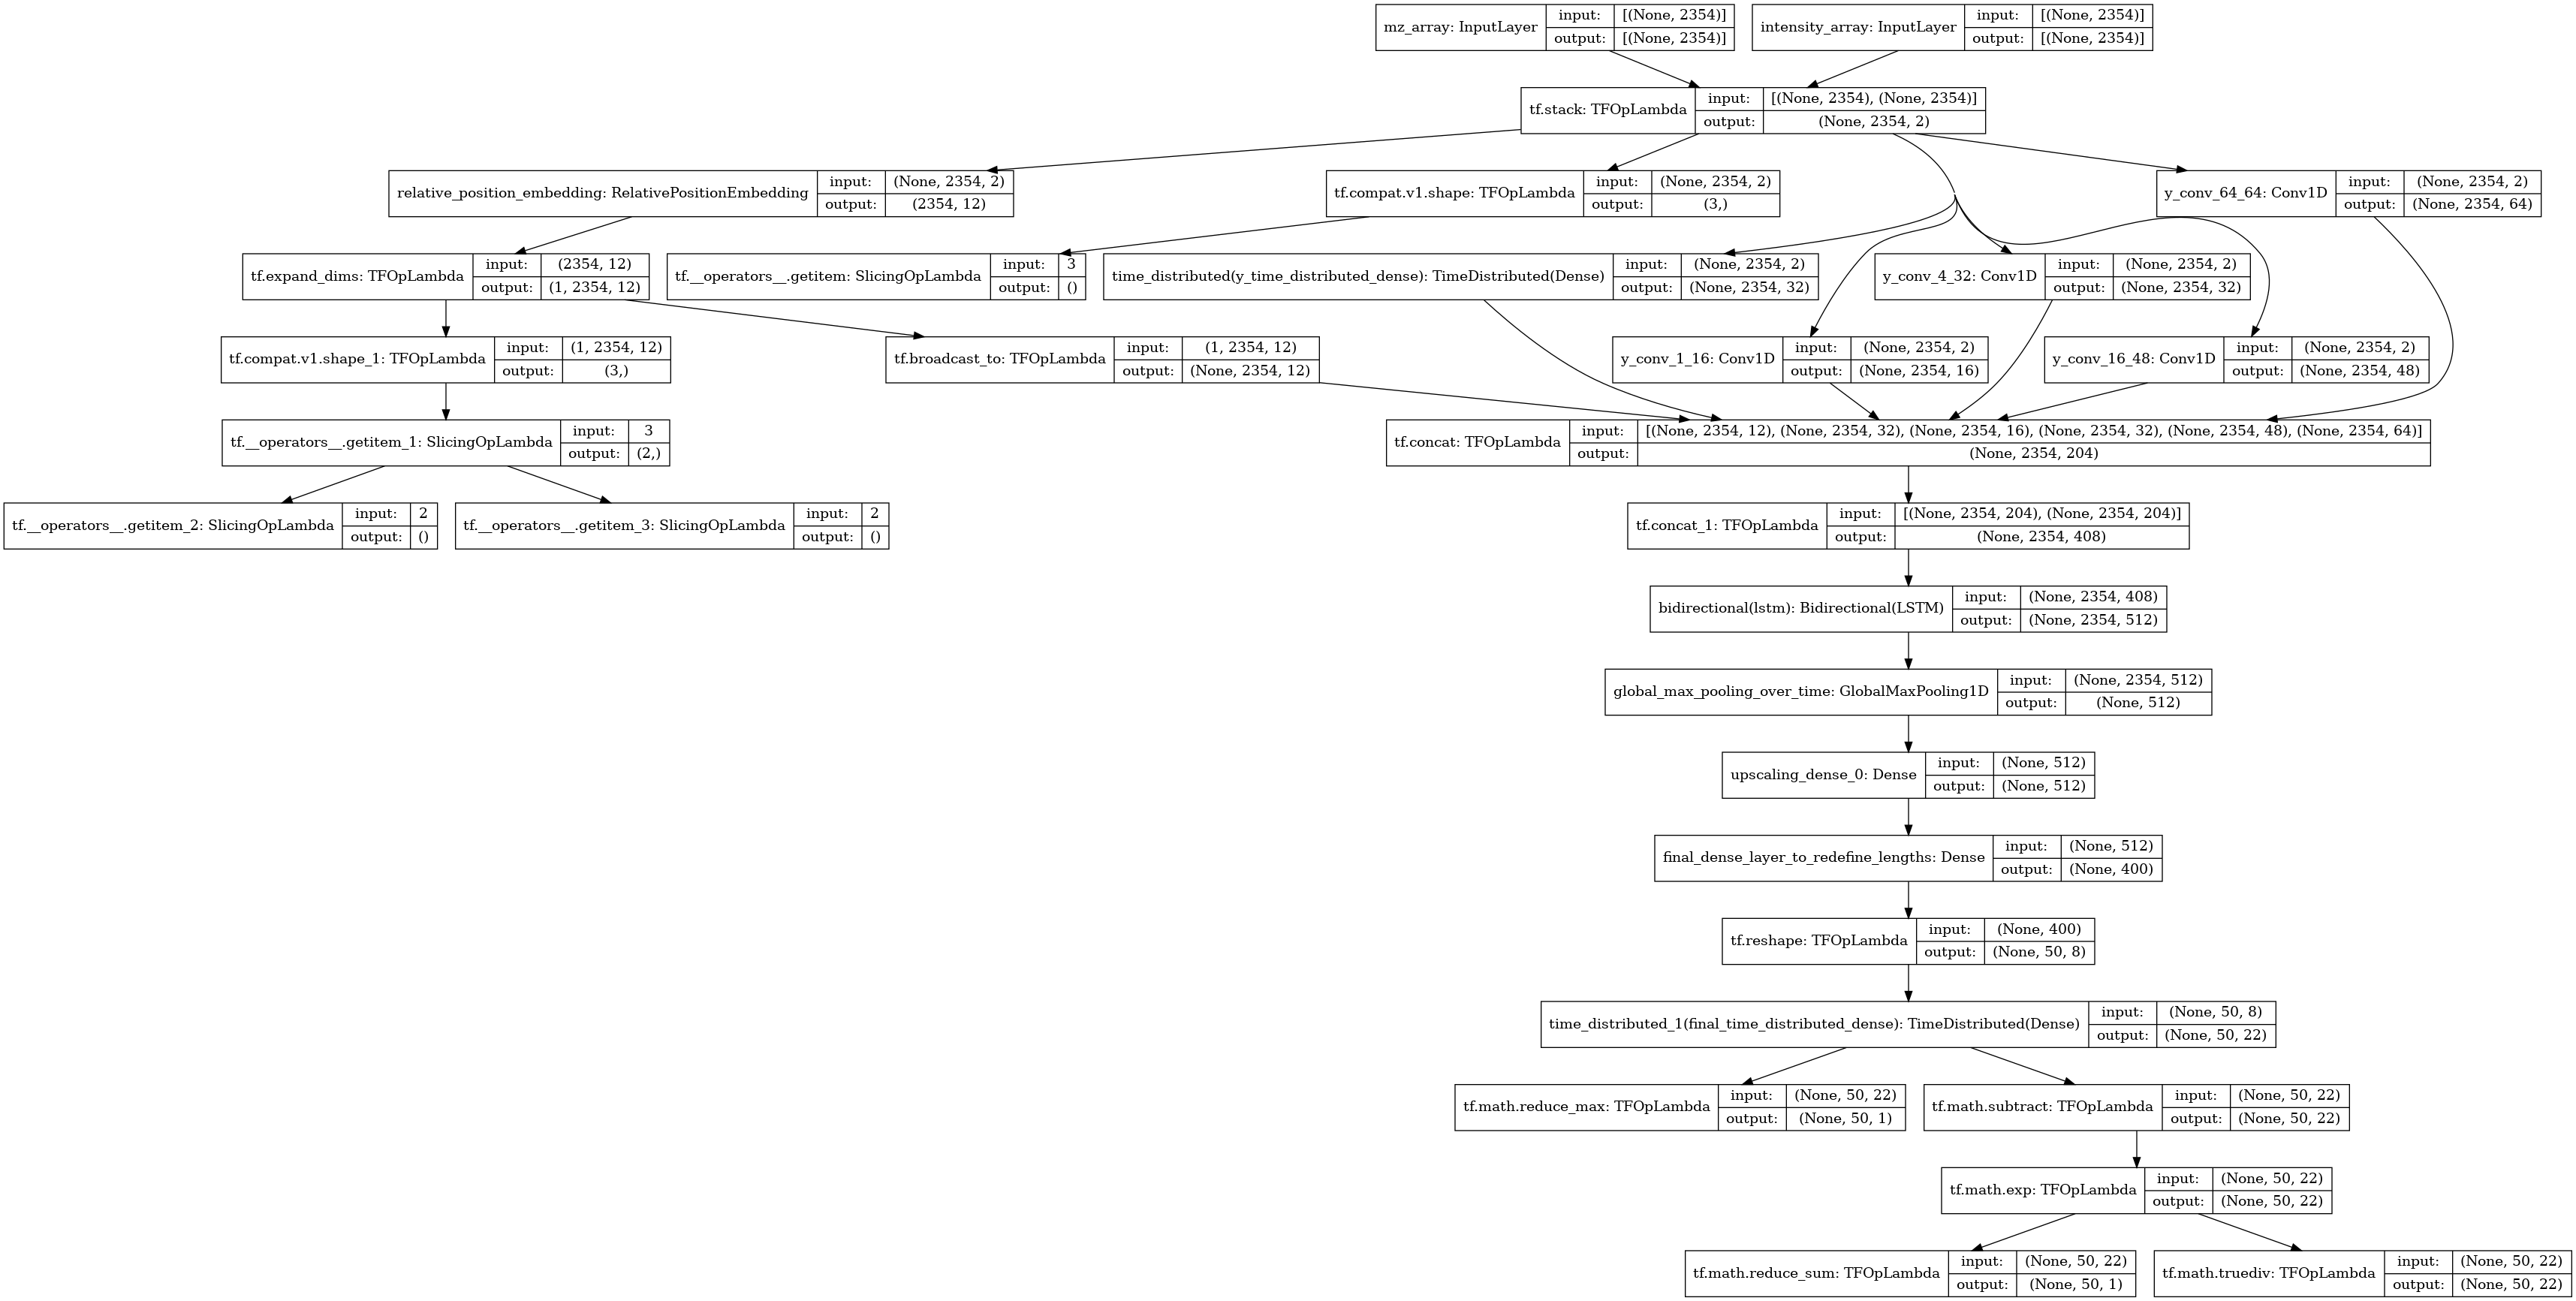

In [102]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [103]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_lstm_with_pooling_and_position_20210714-153149"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 2354)]       0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 2354)]       0                                            
__________________________________________________________________________________________________
tf.stack (TFOpLambda)           (None, 2354, 2)      0           mz_array[0][0]                   
                                                                 intensity_array[0][0]            
__________________________________________________________________________________________________
relative_position_embedding (Re (2354, 12)  

In [104]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [105]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

## Training the Tensorflow Model

In [106]:
training_dataset = datasets[TRAINING_TYPE].repeat()
validation_dataset = datasets[TEST_TYPE].repeat()

In [109]:
history = model.fit(
    x=training_dataset,
    validation_data=validation_dataset, 
    validation_steps=200,
    epochs=150,
    steps_per_epoch=1_000,
    callbacks=callbacks.create_callbacks(
        tensorboard=True,
        progressbar=False,
        reduce_lr=True,
        early_stopping=False,
        checkpoints=True,
        csv=False,
        base_path=MODEL_PATH,
    )
)
history

Epoch 1/150
1000/1000 [==============================] - 334s 332ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.6474 - sparse_categorical_crossentropy: 1.2502 - val_loss: 1.1945 - val_sparse_categorical_accuracy: 0.6733 - val_sparse_categorical_crossentropy: 1.1945


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 2/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2231 - sparse_categorical_accuracy: 0.6573 - sparse_categorical_crossentropy: 1.2231 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.6729 - val_sparse_categorical_crossentropy: 1.1867


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 3/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2369 - sparse_categorical_accuracy: 0.6535 - sparse_categorical_crossentropy: 1.2369 - val_loss: 1.1877 - val_sparse_categorical_accuracy: 0.6659 - val_sparse_categorical_crossentropy: 1.1877


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 4/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.3073 - sparse_categorical_accuracy: 0.6346 - sparse_categorical_crossentropy: 1.3073 - val_loss: 1.1926 - val_sparse_categorical_accuracy: 0.6677 - val_sparse_categorical_crossentropy: 1.1926


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 5/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.3021 - sparse_categorical_accuracy: 0.6380 - sparse_categorical_crossentropy: 1.3021 - val_loss: 1.1802 - val_sparse_categorical_accuracy: 0.6677 - val_sparse_categorical_crossentropy: 1.1802


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 6/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2397 - sparse_categorical_accuracy: 0.6552 - sparse_categorical_crossentropy: 1.2397 - val_loss: 1.1771 - val_sparse_categorical_accuracy: 0.6678 - val_sparse_categorical_crossentropy: 1.1771


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 8/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2182 - sparse_categorical_accuracy: 0.6641 - sparse_categorical_crossentropy: 1.2182 - val_loss: 1.1795 - val_sparse_categorical_accuracy: 0.6790 - val_sparse_categorical_crossentropy: 1.1795


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 9/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.6652 - sparse_categorical_crossentropy: 1.2174 - val_loss: 1.1785 - val_sparse_categorical_accuracy: 0.6782 - val_sparse_categorical_crossentropy: 1.1785


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 10/150
 214/1000 [=====>........................] - ETA: 4:02 - loss: 1.2265 - sparse_categorical_accuracy: 0.6625 - sparse_categorical_crossentropy: 1.2265

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2737 - sparse_categorical_accuracy: 0.6566 - sparse_categorical_crossentropy: 1.2737 - val_loss: 1.2040 - val_sparse_categorical_accuracy: 0.6744 - val_sparse_categorical_crossentropy: 1.2040


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 22/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.6663 - sparse_categorical_crossentropy: 1.2387 - val_loss: 1.1768 - val_sparse_categorical_accuracy: 0.6813 - val_sparse_categorical_crossentropy: 1.1768


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 23/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2196 - sparse_categorical_accuracy: 0.6697 - sparse_categorical_crossentropy: 1.2196 - val_loss: 1.1956 - val_sparse_categorical_accuracy: 0.6774 - val_sparse_categorical_crossentropy: 1.1956


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 24/150
 238/1000 [======>.......................] - ETA: 3:53 - loss: 1.2182 - sparse_categorical_accuracy: 0.6682 - sparse_categorical_crossentropy: 1.2182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.1443 - sparse_categorical_accuracy: 0.6900 - sparse_categorical_crossentropy: 1.1443 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.6779 - val_sparse_categorical_crossentropy: 1.1860


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 36/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.1992 - sparse_categorical_accuracy: 0.6745 - sparse_categorical_crossentropy: 1.1992 - val_loss: 1.1789 - val_sparse_categorical_accuracy: 0.6799 - val_sparse_categorical_crossentropy: 1.1789


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 37/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.1554 - sparse_categorical_accuracy: 0.6853 - sparse_categorical_crossentropy: 1.1554 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.6838 - val_sparse_categorical_crossentropy: 1.1540


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 38/150
 406/1000 [===========>..................] - ETA: 3:02 - loss: 1.1436 - sparse_categorical_accuracy: 0.6869 - sparse_categorical_crossentropy: 1.1436

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2647 - sparse_categorical_accuracy: 0.6503 - sparse_categorical_crossentropy: 1.2647 - val_loss: 1.1773 - val_sparse_categorical_accuracy: 0.6769 - val_sparse_categorical_crossentropy: 1.1773


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 50/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2287 - sparse_categorical_accuracy: 0.6602 - sparse_categorical_crossentropy: 1.2287 - val_loss: 1.1788 - val_sparse_categorical_accuracy: 0.6760 - val_sparse_categorical_crossentropy: 1.1788


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 51/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2054 - sparse_categorical_accuracy: 0.6652 - sparse_categorical_crossentropy: 1.2054 - val_loss: 1.1630 - val_sparse_categorical_accuracy: 0.6810 - val_sparse_categorical_crossentropy: 1.1630


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 52/150
 872/1000 [=========================>....] - ETA: 39s - loss: 1.2470 - sparse_categorical_accuracy: 0.6519 - sparse_categorical_crossentropy: 1.2470

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2126 - sparse_categorical_accuracy: 0.6673 - sparse_categorical_crossentropy: 1.2126 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.6773 - val_sparse_categorical_crossentropy: 1.1867


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 65/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.6512 - sparse_categorical_crossentropy: 1.2706 - val_loss: 1.1662 - val_sparse_categorical_accuracy: 0.6824 - val_sparse_categorical_crossentropy: 1.1662


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 66/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2961 - sparse_categorical_accuracy: 0.6438 - sparse_categorical_crossentropy: 1.2961 - val_loss: 1.1752 - val_sparse_categorical_accuracy: 0.6801 - val_sparse_categorical_crossentropy: 1.1752


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 67/150
 642/1000 [==================>...........] - ETA: 1:49 - loss: 1.3039 - sparse_categorical_accuracy: 0.6418 - sparse_categorical_crossentropy: 1.3039

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2522 - sparse_categorical_accuracy: 0.6565 - sparse_categorical_crossentropy: 1.2522 - val_loss: 1.1725 - val_sparse_categorical_accuracy: 0.6810 - val_sparse_categorical_crossentropy: 1.1725


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 80/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2154 - sparse_categorical_accuracy: 0.6699 - sparse_categorical_crossentropy: 1.2154 - val_loss: 1.1810 - val_sparse_categorical_accuracy: 0.6784 - val_sparse_categorical_crossentropy: 1.1810


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 81/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.1539 - sparse_categorical_accuracy: 0.6864 - sparse_categorical_crossentropy: 1.1539 - val_loss: 1.1812 - val_sparse_categorical_accuracy: 0.6798 - val_sparse_categorical_crossentropy: 1.1812


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 82/150
 138/1000 [===>..........................] - ETA: 4:24 - loss: 1.1374 - sparse_categorical_accuracy: 0.6894 - sparse_categorical_crossentropy: 1.1374

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.6539 - sparse_categorical_crossentropy: 1.2600 - val_loss: 1.1721 - val_sparse_categorical_accuracy: 0.6803 - val_sparse_categorical_crossentropy: 1.1721


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 94/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.6608 - sparse_categorical_crossentropy: 1.2377 - val_loss: 1.1787 - val_sparse_categorical_accuracy: 0.6795 - val_sparse_categorical_crossentropy: 1.1788


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 95/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.1741 - sparse_categorical_accuracy: 0.6798 - sparse_categorical_crossentropy: 1.1741 - val_loss: 1.1832 - val_sparse_categorical_accuracy: 0.6776 - val_sparse_categorical_crossentropy: 1.1832


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 96/150
 411/1000 [===========>..................] - ETA: 3:00 - loss: 1.1787 - sparse_categorical_accuracy: 0.6778 - sparse_categorical_crossentropy: 1.1787

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 331s 331ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.6712 - sparse_categorical_crossentropy: 1.2013 - val_loss: 1.1802 - val_sparse_categorical_accuracy: 0.6795 - val_sparse_categorical_crossentropy: 1.1802

Epoch 00107: ReduceLROnPlateau reducing learning rate to 9.999998606957661e-11.


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 108/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.6515 - sparse_categorical_crossentropy: 1.2755 - val_loss: 1.1825 - val_sparse_categorical_accuracy: 0.6785 - val_sparse_categorical_crossentropy: 1.1825


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 109/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2233 - sparse_categorical_accuracy: 0.6664 - sparse_categorical_crossentropy: 1.2233 - val_loss: 1.1772 - val_sparse_categorical_accuracy: 0.6795 - val_sparse_categorical_crossentropy: 1.1772


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 110/150
 508/1000 [==============>...............] - ETA: 2:30 - loss: 1.2159 - sparse_categorical_accuracy: 0.6674 - sparse_categorical_crossentropy: 1.2159

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2269 - sparse_categorical_accuracy: 0.6609 - sparse_categorical_crossentropy: 1.2269 - val_loss: 1.1767 - val_sparse_categorical_accuracy: 0.6793 - val_sparse_categorical_crossentropy: 1.1767


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 121/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2550 - sparse_categorical_accuracy: 0.6519 - sparse_categorical_crossentropy: 1.2550 - val_loss: 1.1685 - val_sparse_categorical_accuracy: 0.6803 - val_sparse_categorical_crossentropy: 1.1685


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 122/150
 502/1000 [==============>...............] - ETA: 2:33 - loss: 1.2113 - sparse_categorical_accuracy: 0.6665 - sparse_categorical_crossentropy: 1.2113

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.1688 - sparse_categorical_accuracy: 0.6774 - sparse_categorical_crossentropy: 1.1688 - val_loss: 1.1705 - val_sparse_categorical_accuracy: 0.6805 - val_sparse_categorical_crossentropy: 1.1705


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 124/150
 277/1000 [=======>......................] - ETA: 3:42 - loss: 1.1905 - sparse_categorical_accuracy: 0.6712 - sparse_categorical_crossentropy: 1.1905

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 1.2522 - sparse_categorical_accuracy: 0.6558 - sparse_categorical_crossentropy: 1.2522 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.6773 - val_sparse_categorical_crossentropy: 1.1860


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 134/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2871 - sparse_categorical_accuracy: 0.6460 - sparse_categorical_crossentropy: 1.2871 - val_loss: 1.1691 - val_sparse_categorical_accuracy: 0.6816 - val_sparse_categorical_crossentropy: 1.1691


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 135/150
1000/1000 [==============================] - 331s 331ms/step - loss: 1.2925 - sparse_categorical_accuracy: 0.6442 - sparse_categorical_crossentropy: 1.2925 - val_loss: 1.1896 - val_sparse_categorical_accuracy: 0.6770 - val_sparse_categorical_crossentropy: 1.1896


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 136/150
 844/1000 [========================>.....] - ETA: 47s - loss: 1.2996 - sparse_categorical_accuracy: 0.6420 - sparse_categorical_crossentropy: 1.2996

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 331s 331ms/step - loss: 1.2318 - sparse_categorical_accuracy: 0.6620 - sparse_categorical_crossentropy: 1.2318 - val_loss: 1.1837 - val_sparse_categorical_accuracy: 0.6776 - val_sparse_categorical_crossentropy: 1.1837

Epoch 00147: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 148/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.6592 - sparse_categorical_crossentropy: 1.2494 - val_loss: 1.1740 - val_sparse_categorical_accuracy: 0.6807 - val_sparse_categorical_crossentropy: 1.1740


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 149/150
1000/1000 [==============================] - 332s 332ms/step - loss: 1.1762 - sparse_categorical_accuracy: 0.6809 - sparse_categorical_crossentropy: 1.1762 - val_loss: 1.1973 - val_sparse_categorical_accuracy: 0.6757 - val_sparse_categorical_crossentropy: 1.1973


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/dumps/PXD010000/models/mmproteo_lstm_with_pooling_and_position_20210714-153149/checkpoints/assets


Epoch 150/150
 182/1000 [====>.........................] - ETA: 4:10 - loss: 1.1516 - sparse_categorical_accuracy: 0.6867 - sparse_categorical_crossentropy: 1.1516

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Evaluating the Tensorflow Model

In [56]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

In [57]:
evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [110]:
evaluator.evaluate_model(model)

1250/1250 [==============================] - 143s 113ms/step - loss: 1.1334 - sparse_categorical_accuracy: 0.6931 - sparse_categorical_crossentropy: 1.1334


[1.1333940029144287, 0.6931279897689819, 1.1333943605422974]

In [111]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,A L A A A A A A,A M E E P L R
1,A L A A A A A A _ _ _ _ _ _ _,E F Q L E S P D Q L E A L R
2,A L A A A A A A A _ A A,I I S E F T E G F D R
3,A L A A A A A A A _ _ _ _,K S E Y N E Q I P E L R
4,A L A A A A A A A _ _ _ _ _,T G G A I D K S E Q L K R
5,A L A A A A A A,I A E I E G K
6,A L A A A A A A _ _ _ _,D D K V L V E G I N R
7,A L A A A A A A A _ A A _ _ _ _ _ _ _,G S A A A G E I A I E A P K E T P K
8,A L A A A A A A A _ A A _ A _ _ _,L T D T P V G E P D T T T P A R
9,A L A A A A A A A _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T L I T P N S P Y D K Y V N G D K S A L T E Q Q V R


In [112]:
eval_df.predicted.map(print)
None

A L A A A A A A
A L A A A A A A _ _ _ _ _ _ _
A L A A A A A A A _ A A
A L A A A A A A A _ _ _ _
A L A A A A A A A _ _ _ _ _
A L A A A A A A
A L A A A A A A _ _ _ _
A L A A A A A A A _ A A _ _ _ _ _ _ _
A L A A A A A A A _ A A _ A _ _ _
A L A A A A A A A _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
A L A A A A A A _ _ _ _ _ _ _ _ _ _
A L A A A A A A _ _ _ _ _ _ _ _
A L A A A A A A A _ A A _ A _ _ _ _ _ _ _ _ _ _ _
A L A A A A A A A _ A _ _ _ _ _ _ _ _ _
A L A A A A A A A _ A
A L A A A A A A A _ A A _ A _ _ _ _ _ _ _ _ _ _ _ _ _ _
A L A A A A A A A _ A A _ A _ _
A L A A A A A A _ _ _ _ _ _
A L A A A A A A A _ _ _ _ _ _ _ _ _
A L A A A A A A A


broken loss function?

In [ ]:
np.argmax(y_pred[0], axis=1)

In [ ]:
model.predict(datasets[EVAL_TYPE].take(1)).shape

In [ ]:
y_pred.shape

In [ ]:
y_pred